In [ ]:
# for gradient cloud env
# %pip install tensorflow==2.8.3
# %pip install tensorflow-datasets==4.7.0

In [1]:
import datetime
import tensorflow as tf
import tensorflow_datasets as tfds 
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, Reshape, GlobalAveragePooling2D, MaxPooling2D, UpSampling2D

In [2]:
def preprocess(data):
    batch_size = 32
    buffer_size = 2000

    data = (
        data.map(lambda image, target: (tf.cast(image, tf.float32)/256, target))
            .map(lambda image, target: (image, image))
            .map(lambda image, target: (image + tf.random.normal(shape=(28,28,1), mean=0, stddev=0.1), target))
            .map(lambda image, target: (tf.clip_by_value(image, 0, 1), target))
    )
    
    data.cache()
    data = (
        data.shuffle(buffer_size)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
    )
    return data

In [17]:
def normalize(data, batch_size):
    batch_size = batch_size

    data = (
        data.map(lambda image: tf.cast(image, tf.float32)/256)
            .map(lambda image: tf.clip_by_value(image, 0, 1))
    )
    
    data.cache()
    data = (
        data.batch(batch_size)
    )
    return data

In [4]:
def visualize(img):
  plt.imshow(img)       
  plt.show()

2023-01-09 09:58:48.770254: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


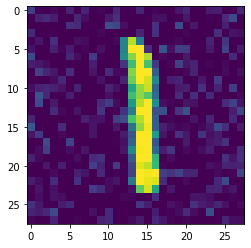

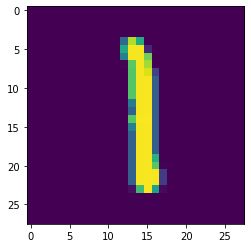

2023-01-09 09:58:52.487373: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
preprocessed_train_ds = preprocess(train_ds)
preprocessed_test_ds = preprocess(test_ds)

for image, target in preprocessed_train_ds.take(1):
    visualize(tf.squeeze(image[0], axis=-1))
    visualize(tf.squeeze(target[0], axis=-1))

# Encoder


In [6]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(64, 3, activation='relu', padding='same') # 28*28*64
    self.pooling1 = MaxPooling2D(2) # 14*14*64
    self.conv3 = Conv2D(32, 3, activation='relu', padding='same') # 14*14*32
    self.pooling2 = MaxPooling2D(2) # 7*7*32
    self.conv5 = Conv2D(16, 3, activation='relu', padding='same') # 7*7*16
    self.globalpooling = GlobalAveragePooling2D() # 16
    self.out = Dense(10, activation="relu")


  @tf.function
  def __call__(self, x, training=False):
    x = self.conv1(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.pooling2(x)
    x = self.conv5(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

In [7]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(49, activation="relu")
        self.reshape = Reshape((7, 7, 1))
        self.conv1 = Conv2D(16, 3, activation="relu", padding="same")
        self.upsampling1 = UpSampling2D(2)
        self.conv2 = Conv2D(32, 3, activation="relu", padding="same")
        self.upsampling2 = UpSampling2D(2)
        self.conv_output = Conv2D(1, 3, activation="sigmoid", padding="same")

    @tf.function
    def __call__(self, x, training=False):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.upsampling1(x)
        x = self.conv2(x)
        x = self.upsampling2(x)
        x = self.conv_output(x)
        return x

In [8]:
class Autoencoder(tf.keras.Model):
  def __init__(self, optimizer, loss_function):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()

    self.metrics_list = [
      tf.keras.metrics.Mean(name="loss")]

    self.optimizer = optimizer
    self.loss_function = loss_function

  @property
  def metrics(self):
    return self.metrics_list
  
  def get_encoder(self):
    return self.enc
   
  def get_decoder(self):
    return self.dec
    
  def reset_metrics(self):
     for metric in self.metrics:
        metric.reset_state()

  def call(self, input, training=False):
    embedding = self.enc(input)
    output = self.dec(embedding)
    return output

  @tf.function
  def train_step(self, data):
    image, target = data
    with tf.GradientTape() as tape: 
      prediction = self(image, training = True)
      loss = self.loss_function(target, prediction)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
    self.metrics[0].update_state(loss)  
    return gradients

  @tf.function
  def test_step(self, data):
    image, target = data
    prediction = self(image, training = False)
    loss = self.loss_function(target, prediction)
    self.metrics[0].update_state(loss)
    return prediction, target

    

In [9]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0, leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in tqdm(test_ds, position=0, leave=True):
            prediction, target = model.test_step(data)

        visualize(tf.squeeze(prediction[0], axis = -1))
        visualize(tf.squeeze(target[0], axis = -1))


        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)

        print("Loss: ", model.metrics[0].result().numpy(), "(Test)")

100%|██████████| 1875/1875 [00:15<00:00, 122.83it/s]


Epoch:  1
Loss:  0.06310462 (Train)


100%|██████████| 313/313 [00:02<00:00, 121.22it/s]


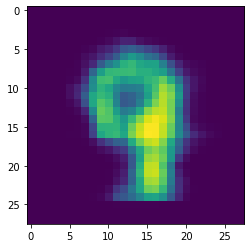

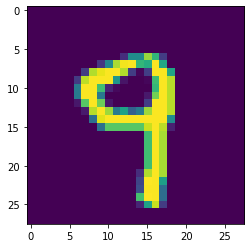

Loss:  0.049157515 (Test)


100%|██████████| 1875/1875 [00:10<00:00, 185.59it/s]


Epoch:  2
Loss:  0.045811623 (Train)


100%|██████████| 313/313 [00:02<00:00, 121.80it/s]


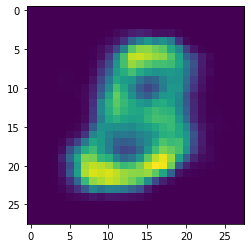

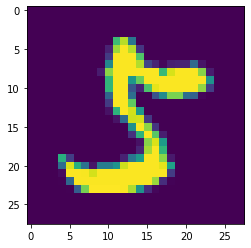

Loss:  0.042420022 (Test)


100%|██████████| 1875/1875 [00:09<00:00, 196.12it/s]


Epoch:  3
Loss:  0.040955156 (Train)


100%|██████████| 313/313 [00:01<00:00, 193.09it/s]


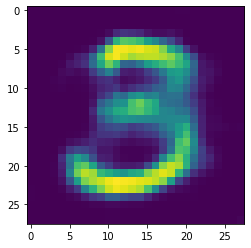

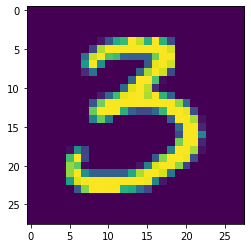

Loss:  0.039371565 (Test)


100%|██████████| 1875/1875 [00:10<00:00, 182.98it/s]


Epoch:  4
Loss:  0.03866922 (Train)


100%|██████████| 313/313 [00:01<00:00, 189.61it/s]


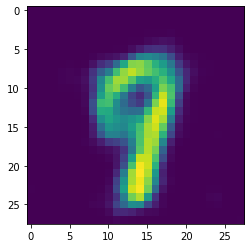

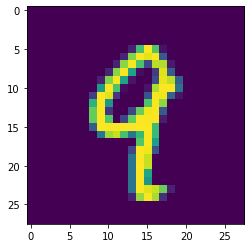

Loss:  0.03777312 (Test)


100%|██████████| 1875/1875 [00:09<00:00, 192.65it/s]


Epoch:  5
Loss:  0.037435964 (Train)


100%|██████████| 313/313 [00:01<00:00, 198.94it/s]


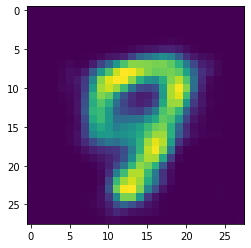

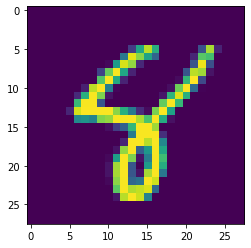

Loss:  0.03669969 (Test)


100%|██████████| 1875/1875 [00:09<00:00, 193.20it/s]


Epoch:  6
Loss:  0.03652457 (Train)


100%|██████████| 313/313 [00:01<00:00, 211.90it/s]


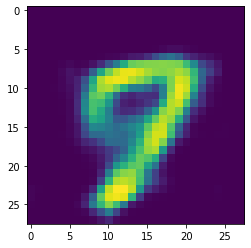

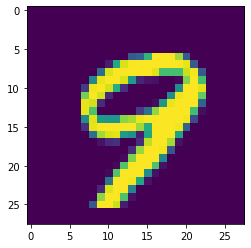

Loss:  0.03591396 (Test)


100%|██████████| 1875/1875 [00:09<00:00, 190.31it/s]


Epoch:  7
Loss:  0.035773523 (Train)


100%|██████████| 313/313 [00:01<00:00, 202.89it/s]


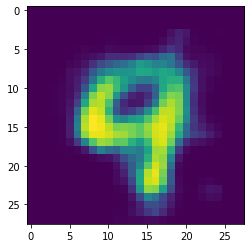

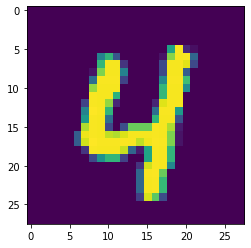

Loss:  0.035187148 (Test)


100%|██████████| 1875/1875 [00:09<00:00, 191.45it/s]


Epoch:  8
Loss:  0.035164174 (Train)


100%|██████████| 313/313 [00:01<00:00, 187.47it/s]


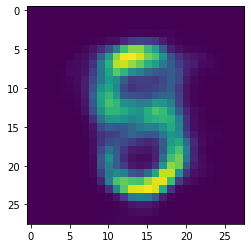

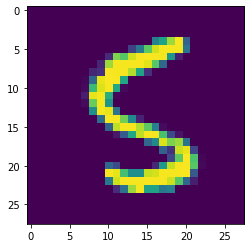

Loss:  0.034805644 (Test)


100%|██████████| 1875/1875 [00:09<00:00, 192.96it/s]


Epoch:  9
Loss:  0.03465177 (Train)


100%|██████████| 313/313 [00:01<00:00, 205.09it/s]


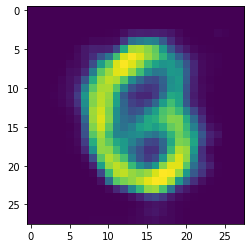

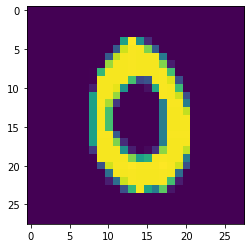

Loss:  0.03401243 (Test)


100%|██████████| 1875/1875 [00:09<00:00, 197.71it/s]


Epoch:  10
Loss:  0.034238774 (Train)


100%|██████████| 313/313 [00:01<00:00, 206.49it/s]


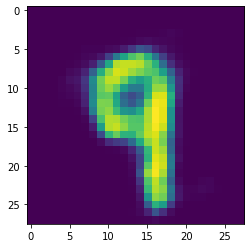

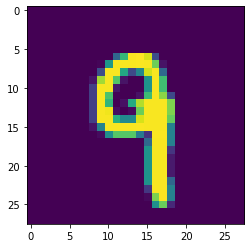

Loss:  0.033908524 (Test)


In [10]:
batch_size = 32
epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.MeanSquaredError()

autoencoder = Autoencoder(optimizer=optimizer, loss_function=loss_function)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(autoencoder, preprocessed_train_ds, preprocessed_test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

# Latent Space Analysis

In [27]:
import numpy as np
from sklearn.manifold import TSNE

images_count = 1000

encoder = autoencoder.get_encoder()

images = [image for image, label in test_ds.take(images_count)]
labels = [label for image, label in test_ds.take(images_count)]

images = tf.convert_to_tensor(images)
images = tf.data.Dataset.from_tensor_slices(images)
images = normalize(images, batch_size=images_count) 

for batch in images:
  embeddings = encoder(batch)
  embeddings_2d = (TSNE(n_components=2).fit_transform(embeddings))

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


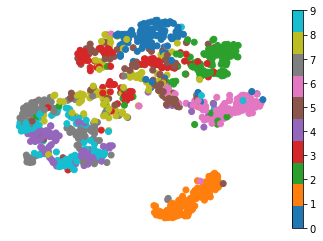

In [43]:
import pandas as pd

labels = np.asarray(labels, dtype=int)

data = pd.DataFrame(data = (embeddings_2d[:,0], embeddings_2d[:,1]))
data = data.T
data["labels"] = labels

plt.scatter(data[0], data[1], c=data[:]["labels"], cmap="tab10")
plt.colorbar()
plt.axis('off')
plt.show()


# Interpolation


targets


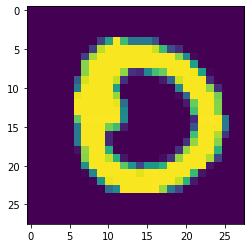

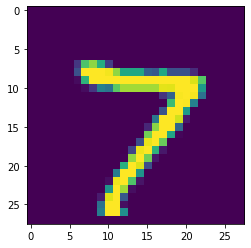

interpolated reconstructions


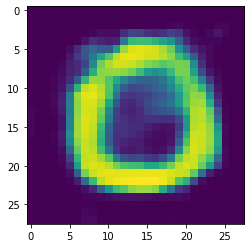

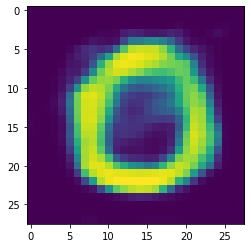

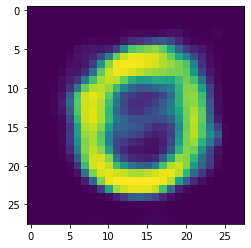

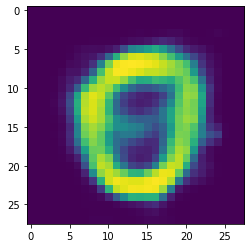

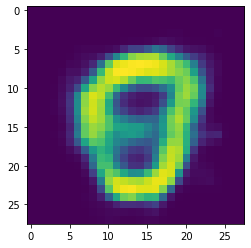

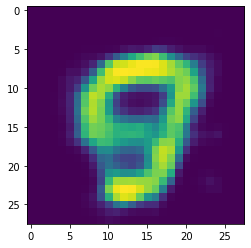

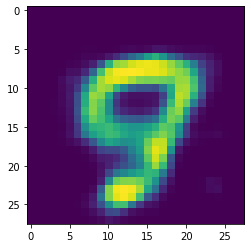

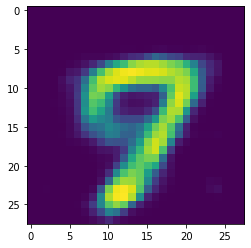

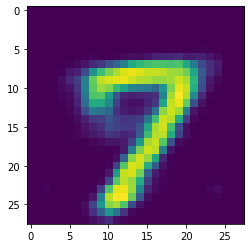

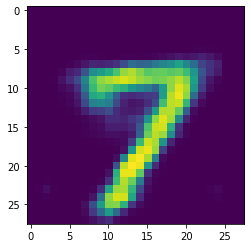

In [44]:
image1 = embeddings[1]
image2 = embeddings[4]


spaces = np.linspace(0,1,10)
in_betweens = []
for x in spaces:
  in_betweens.append(image1 + x *(image2-image1))
in_betweens = tf.convert_to_tensor(in_betweens)

decoder = autoencoder.get_decoder()

print("targets")
for image in images:
  visualize(tf.squeeze(image[1]))
  visualize(tf.squeeze(image[4]))


print("interpolated reconstructions")
for in_between in in_betweens:
  reconstruction = decoder(tf.expand_dims(in_between, axis=0))
  visualize(tf.squeeze(reconstruction))

